# Exploratory Data Analysis
This notebook does not include an in depth methodology or discussion of results. In general, it is written in narrative form, following how I explored, and began to understand, the generated data.

It aims to help communicate my methodology and demonstrate results so we can decide what to focus on for final deliverables.

I'll re-use parts of this for the final deliverables, but with clearer structure and more formal text.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/orion-junkins/eeg-connectivity/blob/main/results_entropy.ipynb)

## 0) Setup
Import needed files and perform necessary setup. Check if we are in Google Colab and clone the repository if so.

In [21]:
import os
import sys
# Check if the notebook is running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Clone the repository if in Colab
if IN_COLAB:
    !pip install pingouin==0.5.5 # Install needed stats library
    !git clone https://github.com/orion-junkins/eeg-connectivity.git # Clone repo
    repo_path = f"/content/eeg-connectivity"
    if os.path.exists(repo_path):
        sys.path.append(repo_path) # Add cloned repo to Python path in colab
        print(f"Cloned connectivity repository and added to Python import path.")
    else:
        print(f"Failed to clone repository.")    
else:
    print("Not running in Google Colab. Skipping repository cloning.")

Not running in Google Colab. Skipping repository cloning.


In [22]:
# Imports
from plotting_utils import plot_heatmap, plot_stacked_triple_ps, plot_condition_diff_avg
from stats_tests import run_wilcoxon, run_anova
from dataset import Dataset

## 1) Load and Explore the Entropy Connectivity Dataset

The `Dataset` abstraction provides lots of helpers for accessing data. I will provide extensive documentation of how to use it in a separate notebook, but here are a couple of example use cases.

In [23]:
# Load the dataset with all data in the folder "connectivity_scores_shannon_entropy"
dataset = Dataset('connectivity_scores_entropy_5s', expert_excludes=["11, 13b", "1"], novice_excludes=["13", "6", "14"], entropy_analysis=True)

Access a single subjects data. In specific, lets grab Expert 9bs Baseline With Gesture data and inspect the shape.

In [24]:
dataset.id_dicts["expert"]["BL"]["WiG"]["9b"].shape

(44, 12, 12, 6)

Note that the shape corresponds to $Epochs \times Electrodes \times Electrodes \times Frequencies$. In this case, we have 44 epochs of data at six different frequency levels. To inspect what frequency values are being used, inspect the `frequencies` attribute of the dataset.

In [25]:
dataset.frequencies

['delta', 'theta', 'low alpha', 'high alpha', 'low beta', 'high beta']

The dataset can also tell us the names of the electrodes it has data for.

In [26]:
dataset.electrode_names

array(['F3', 'Fz', 'F4', 'FCz', 'Cz', 'CP3', 'CP4', 'P1', 'Pz', 'P2',
       'PPO1', 'PPO2'], dtype='<U4')

While this is a nice way to access all raw data for a single subject, for multiple subjects it is easier to work with data as numpy arrays. For this, the dataset provides a `numpy_arrays` arrays attribute. Lets isolate all Expert, Baseline, With Gesture data and inspect the shape.

In [27]:
dataset.numpy_arrays["expert"]["BL"]["WiG"].shape

(16, 12, 12, 6)

The shape corresponds to $Subjects \times Electrodes \times Electrodes \times Frequencies$. Note that, for each subject in a given condition, all epochs have now been averaged into a single value for each electrode pair.

In general, we will want to isolate a single frequency band. While we could do it with indexing, the dataset provides `get_subset(...)` to make things easier. As an example, lets isolate all Expert/BL/WiG/High Alpha data and inspect the shape.

In [28]:
dataset.get_subset("expert", "BL", "WiG", "high alpha").shape

(16, 12, 12)

Note that now we just have $Subjects \times Electrodes \times Electrodes$ as only high alpha data is present.

Lets grab a random subject (say index 5) and visualize their high alpha data.

`plot_heatmap()` is a convenient helper function for visualizing a 2-dimensional array of data as a heatmap with a few options for formatting.

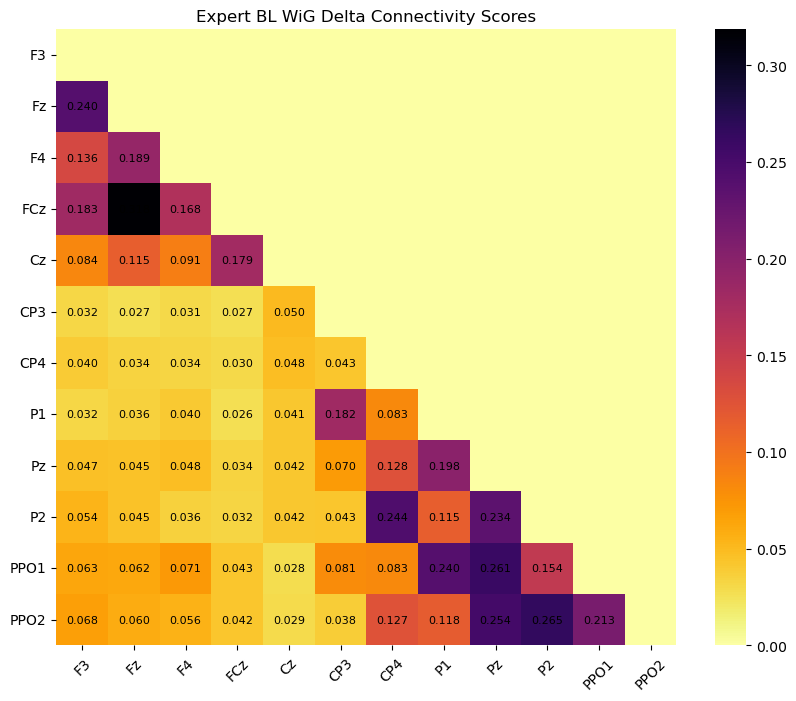

In [29]:
plot_heatmap(dataset.get_subset("expert", "BL", "WiG", "high alpha")[5], dataset.electrode_names, "Expert BL WiG Delta Connectivity Scores")

This shows the raw values for this particular subject at this particular frequency band.

## 2) Statistical Tests

Next lets run some statistical tests to explore our dataset. For now, we will just focus on low alpha, since the majority of the significant results appeared in that band.

Each section will cover a different kind of test. Each section will contain a brief description of how to interpret the results followed by a variety of experiments using different subsets of the data. For each experiment, there will be an **Experiment Setup** and an **Experiment Results** to concisely summarize what the experiment studied and what results were found.

### 2.a) Wilcoxon Signed-Rank Test
This test considers the difference between the two conditions for all subjects. For every electrode pair it provides the median difference of condition 1 - condition 2, test statistics, and p values indicating if the relationship is statistically significant.

In general, we are most concerned with the median difference and the p values.

P values < 0.05 indicate a significant result for a particular electrode pair. Positive median differences indicate that connectivity was generally higher for condition 1. Negative median differences indicate that connectivity was generally higher for condition 2.

#### 2.a.1 Experiment Setup
* Compare demo vs baseline data using Wilcoxon Signed-Rank Test
* Study only low alpha
* Run once for Novice WiG, once for Novice NoG, once for Expert WiG, and once for Expert NoG

Group: novice
Gesticulation: WiG


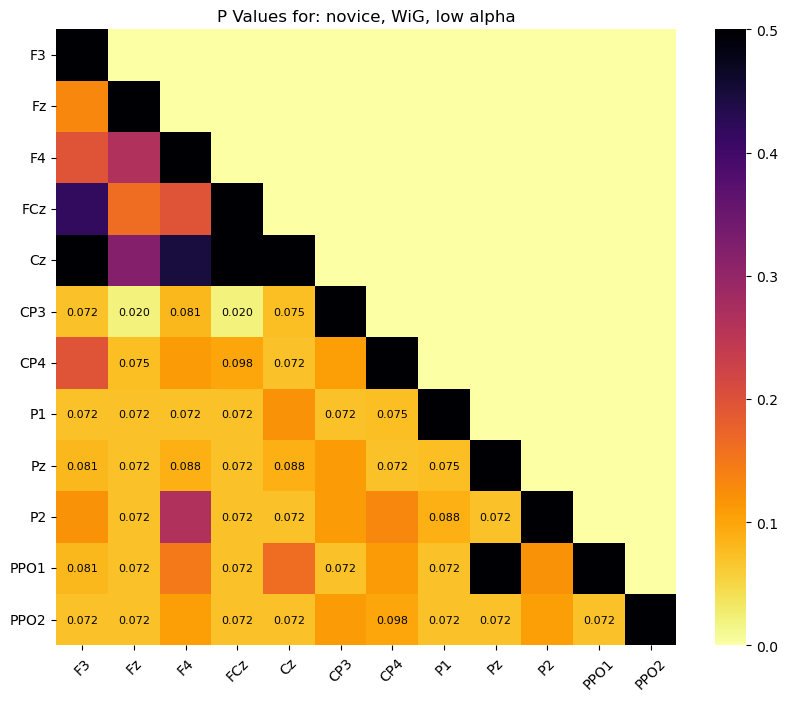

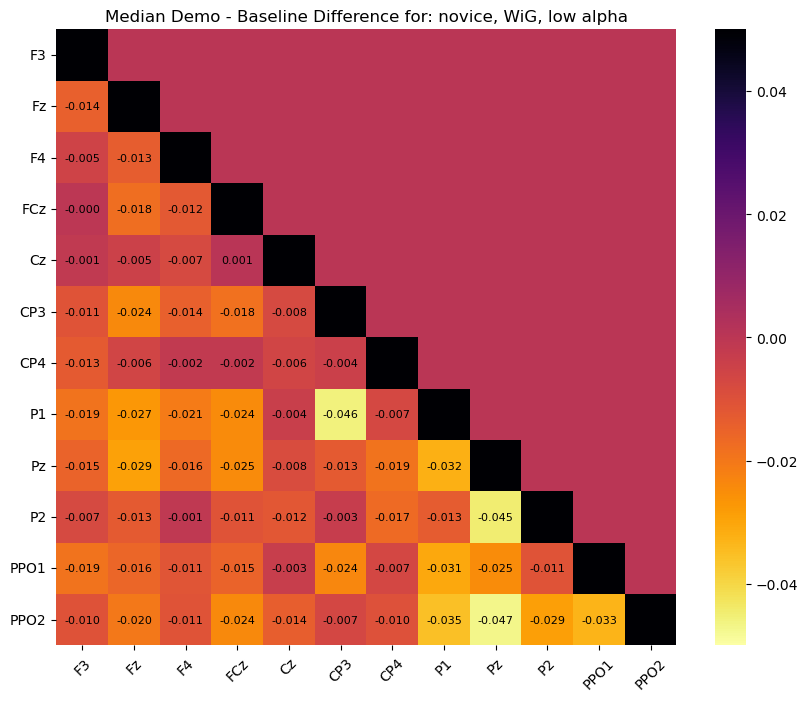

Gesticulation: NoG


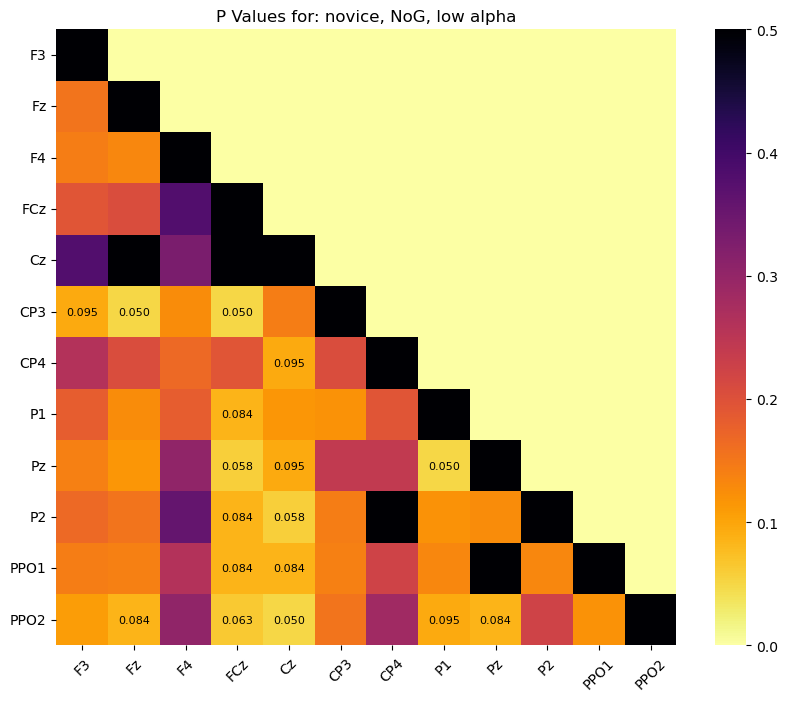

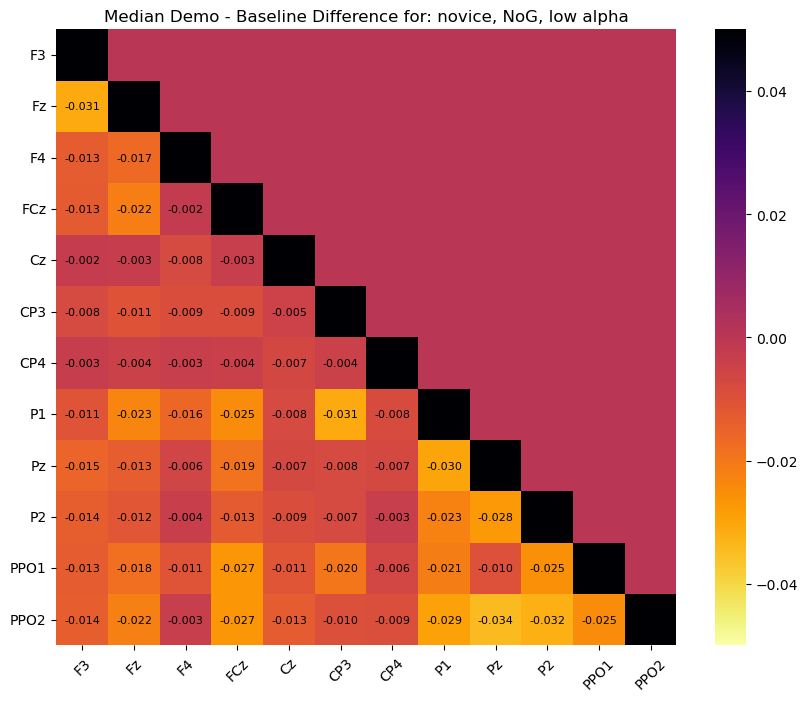

Group: expert
Gesticulation: WiG


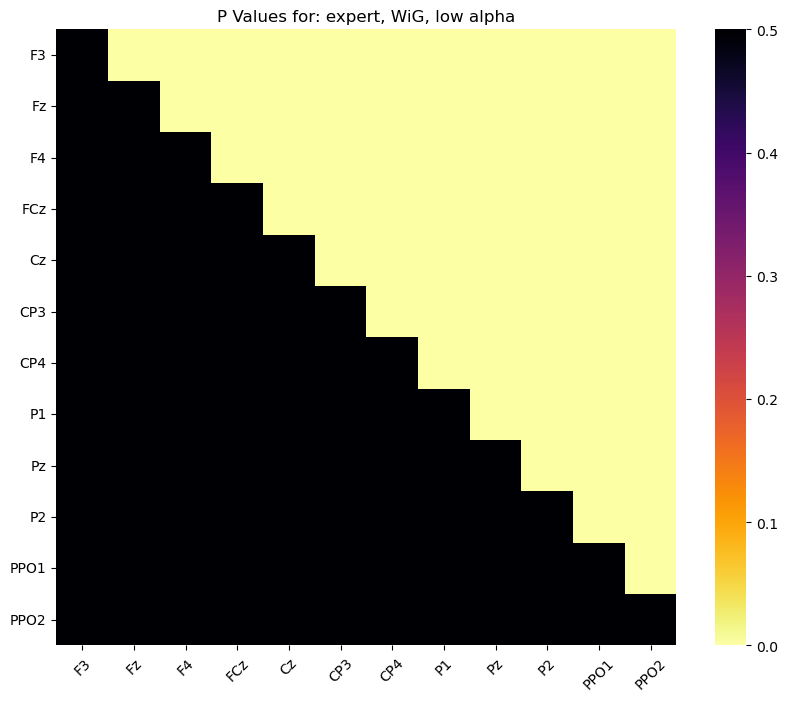

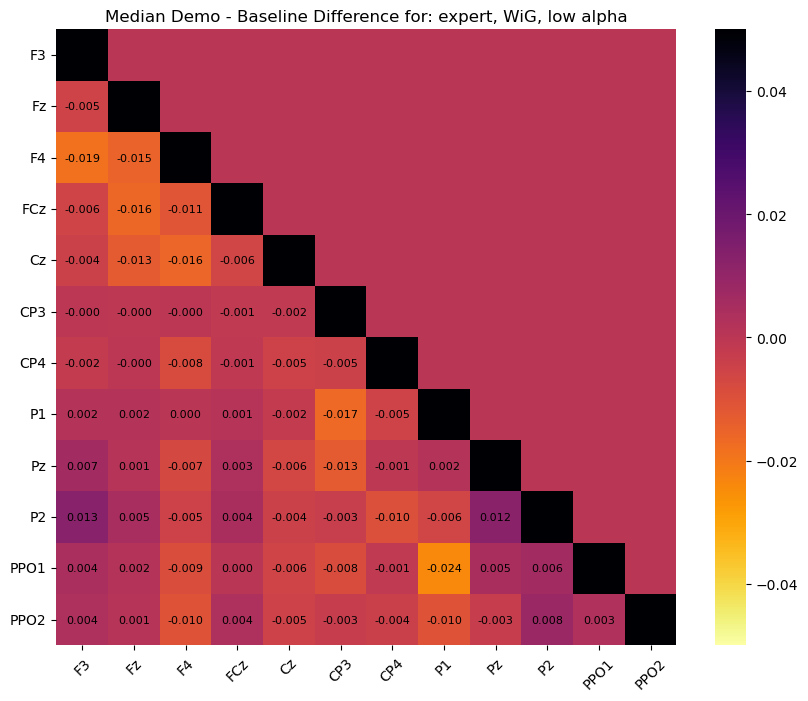

Gesticulation: NoG


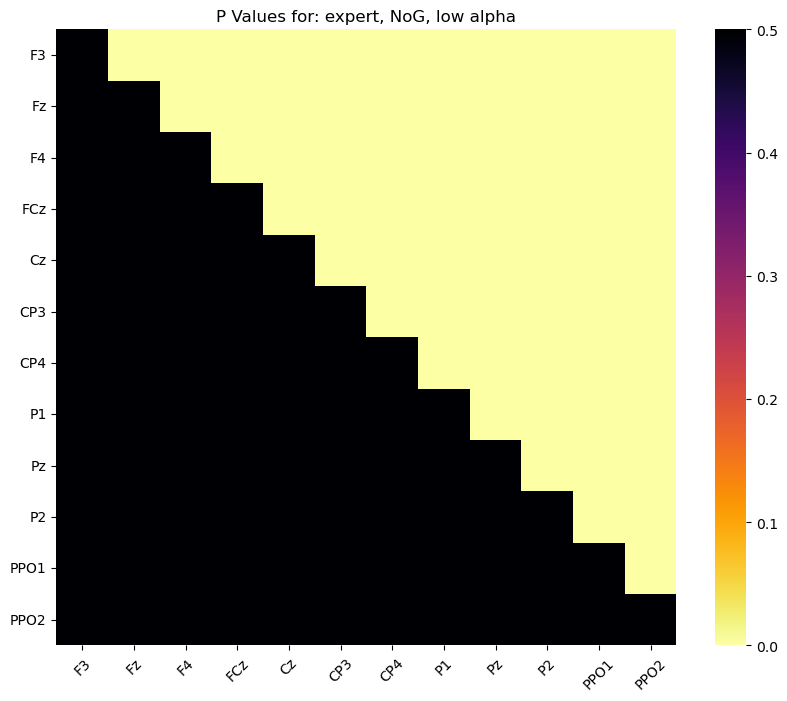

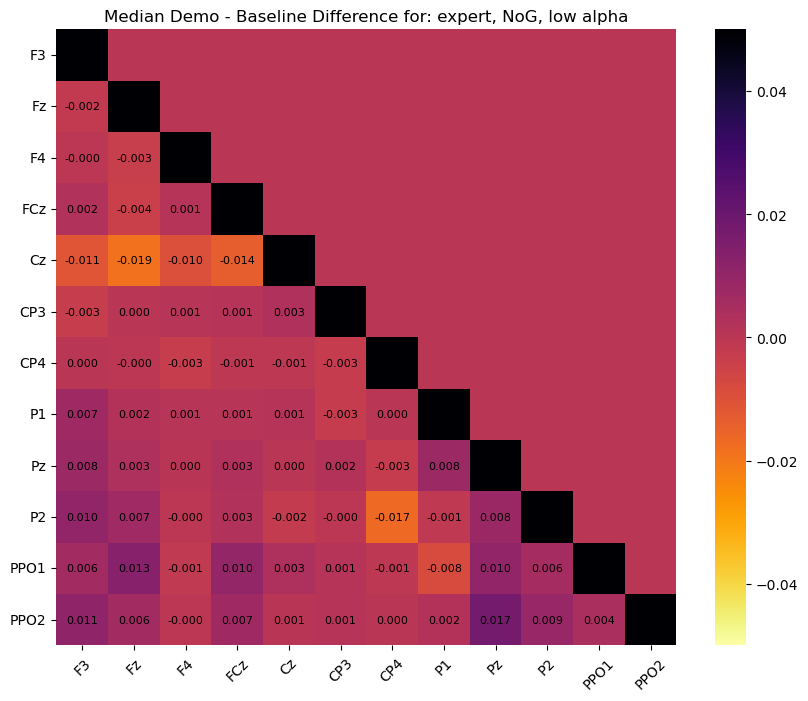

In [30]:
condition_1 = "demo"
condition_2 = "BL"
frequency_band = "low alpha"

for group in ["novice", "expert"]:
    print ("Group: {}".format(group))
    for gesticulation in ["WiG", "NoG"]:
        print("Gesticulation: {}".format(gesticulation))
        condition_1_data = dataset.get_frequency_average(group, condition_1, gesticulation, frequency_band)
        condition_2_data = dataset.get_frequency_average(group, condition_2, gesticulation, frequency_band)
        p_values, test_stats, median_diffs = run_wilcoxon(condition_1_data, condition_2_data)
        plot_heatmap(p_values, dataset.electrode_names, "P Values for: {}, {}, {}".format(group, gesticulation, frequency_band), print_max=0.1, vmin=0, vmax=0.5)
        plot_heatmap(median_diffs, dataset.electrode_names, "Median Demo - Baseline Difference for: {}, {}, {}".format(group, gesticulation, frequency_band), vmax=0.05, vmin=-0.05)

#### 2.a.1 Experiment Results:
* For experts, results were completely insignificant. This implies that performing a cognitively challenging task **does not** impact low alpha connectivity in experts compared to baseline.
* For novices, there were significant results. Specifically, Cp3/Fz and CP3/FCz in both NoG and WiG, and P1/Pz and Cz/PPO2 in NoG. Several other results were nearly significant with p values in the (0.5, 1.0] range.
* For novices, for all significant results, the median difference was negative implying that low alpha connectivity was **higher** during baseline than during demonstration.

#### 2.a.1 Possible Explanations of Results:
* Cognitively challenging tasks cause alpha desynchronization. For experts, describing mathematical concepts is not cognitively challenging, and thus does not cause a substantial difference in synchrony metrics. For novices, the task is challenging causing a significant decrease in low alpha synchrony.


#### 2.a.2 Experiment Setup
* Compare demo vs baseline data using Wilcoxon Signed-Rank Test
* Study only high alpha
* Run once for Novice WiG, once for Novice NoG, once for Expert WiG, and once for Expert NoG

Group: novice
Gesticulation: WiG


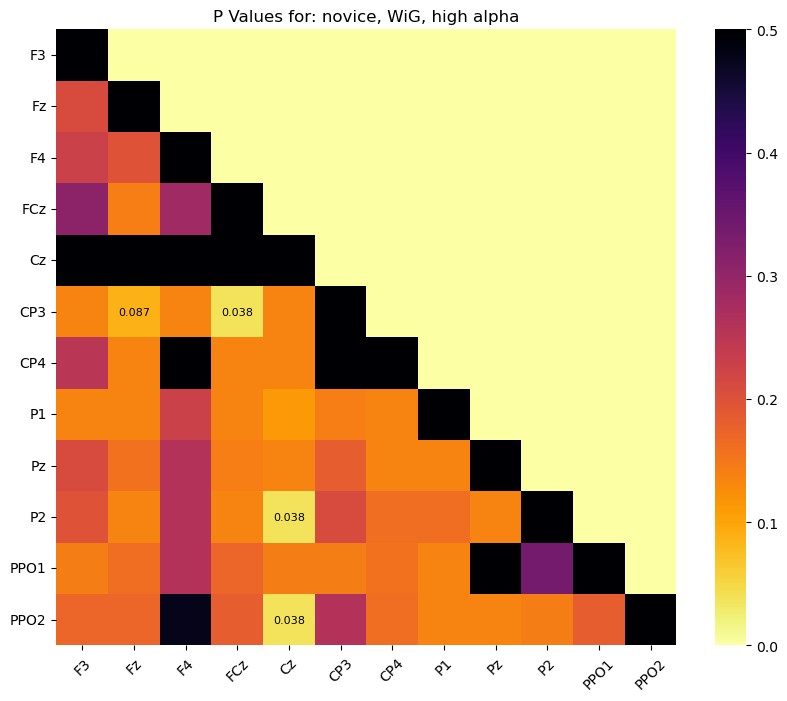

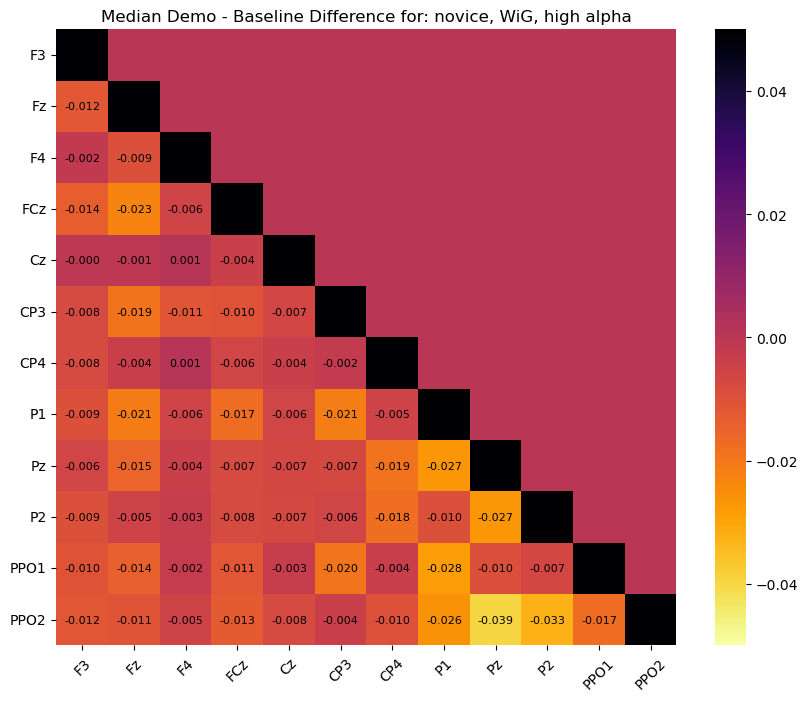

Gesticulation: NoG


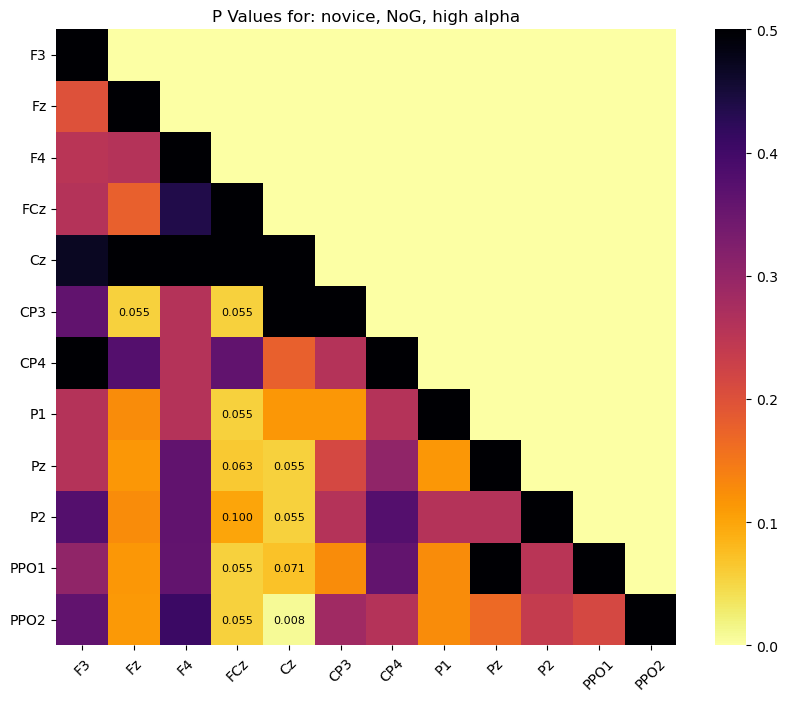

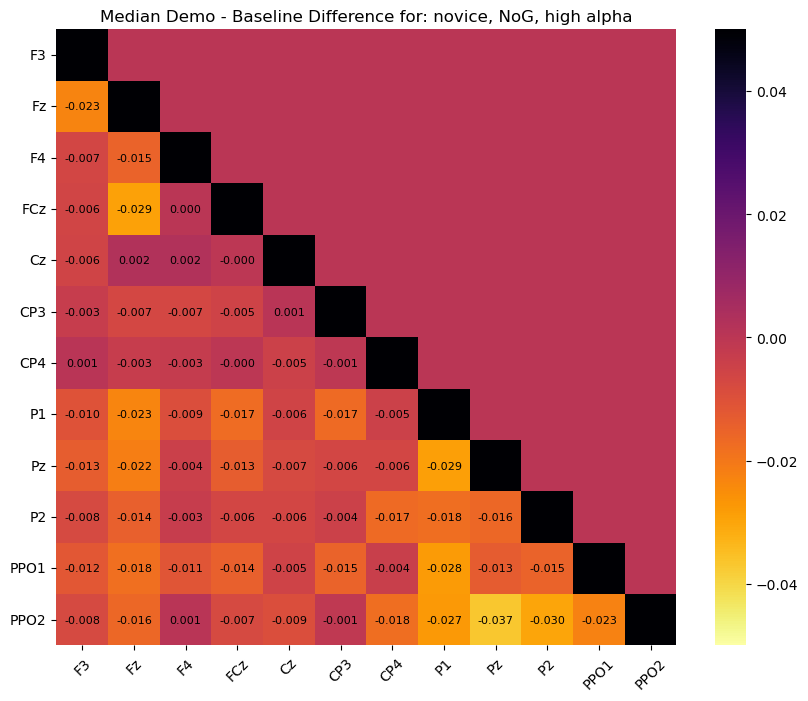

Group: expert
Gesticulation: WiG


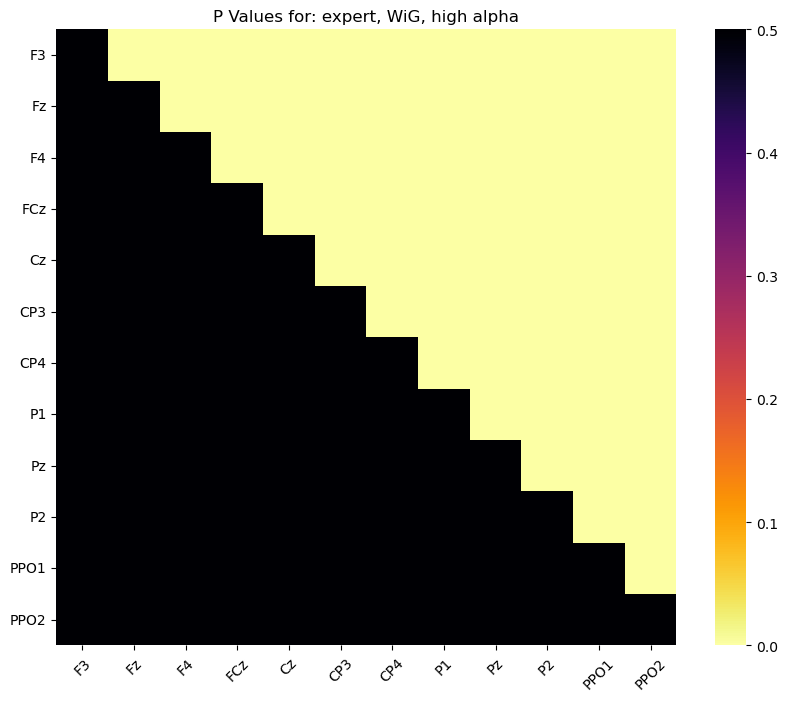

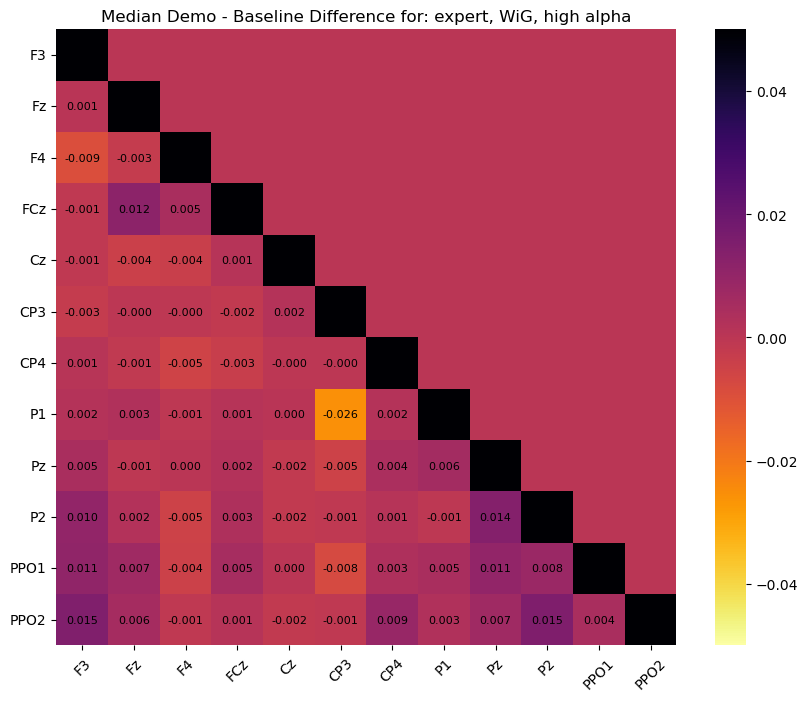

Gesticulation: NoG


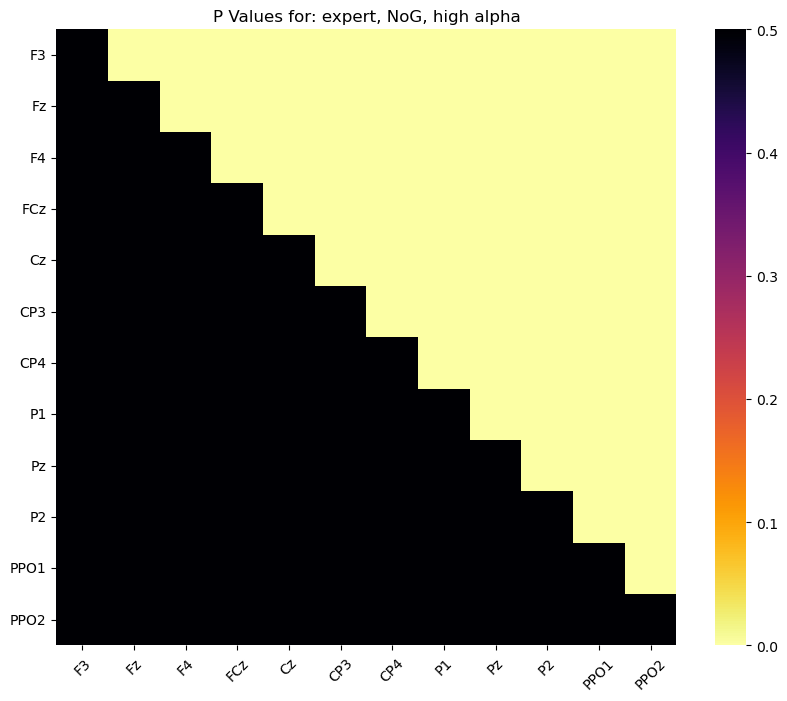

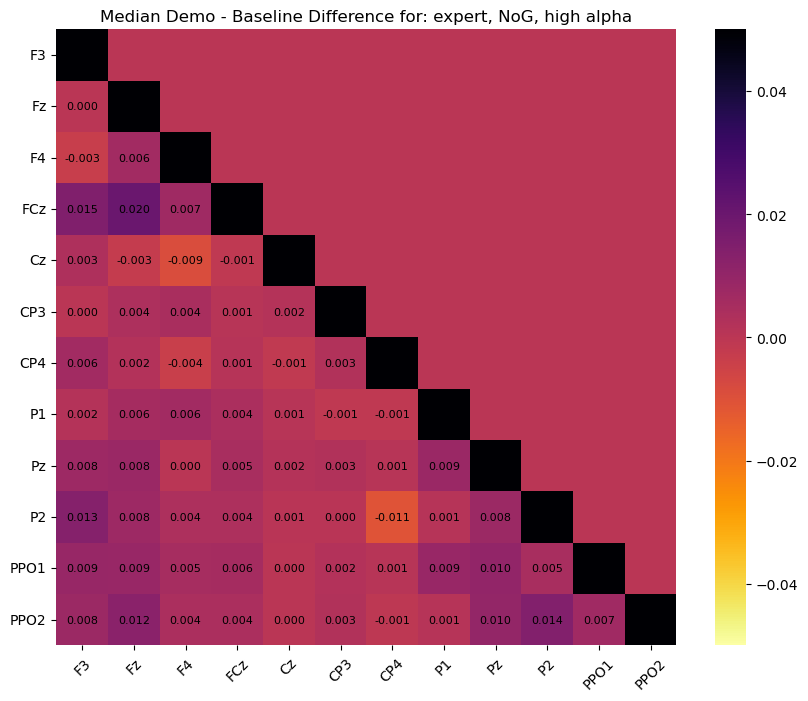

In [31]:
condition_1 = "demo"
condition_2 = "BL"
frequency_band = "high alpha"

for group in ["novice", "expert"]:
    print ("Group: {}".format(group))
    for gesticulation in ["WiG", "NoG"]:
        print("Gesticulation: {}".format(gesticulation))
        condition_1_data = dataset.get_frequency_average(group, condition_1, gesticulation, frequency_band)
        condition_2_data = dataset.get_frequency_average(group, condition_2, gesticulation, frequency_band)
        p_values, test_stats, median_diffs = run_wilcoxon(condition_1_data, condition_2_data)

        plot_heatmap(p_values, dataset.electrode_names, "P Values for: {}, {}, {}".format(group, gesticulation, frequency_band), print_max=0.1, vmin=0, vmax=0.5)
        plot_heatmap(median_diffs, dataset.electrode_names, "Median Demo - Baseline Difference for: {}, {}, {}".format(group, gesticulation, frequency_band), vmax=0.05, vmin=-0.05)

#### 2.a.2 Experiment Results:
* For experts, results were completely insignificant. This reaffirms the result found for low alpha.
* For novices, there were significant results. Specifically, Cz/PPO2 in both NoG and WiG, and CZ/P2 and FCz/CP3 in WiG. Several other results were nearly significant with p values in the (0.5, 1.0] range.
* For novices, for all significant results, the median difference was negative implying that low alpha connectivity was **higher** during baseline than during demonstration.

#### 2.a.2 Possible Explanations of Results:
* Same general conclusions as 2.a.1.


#### 2.a.3 Experiment Setup
* Compare WiG vs NoG data using Wilcoxon Signed-Rank Test
* Study only low alpha
* Run once for Novice demo, once for Novice BL, once for Expert demo, and once for Expert BL

Group: novice
Condition: demo


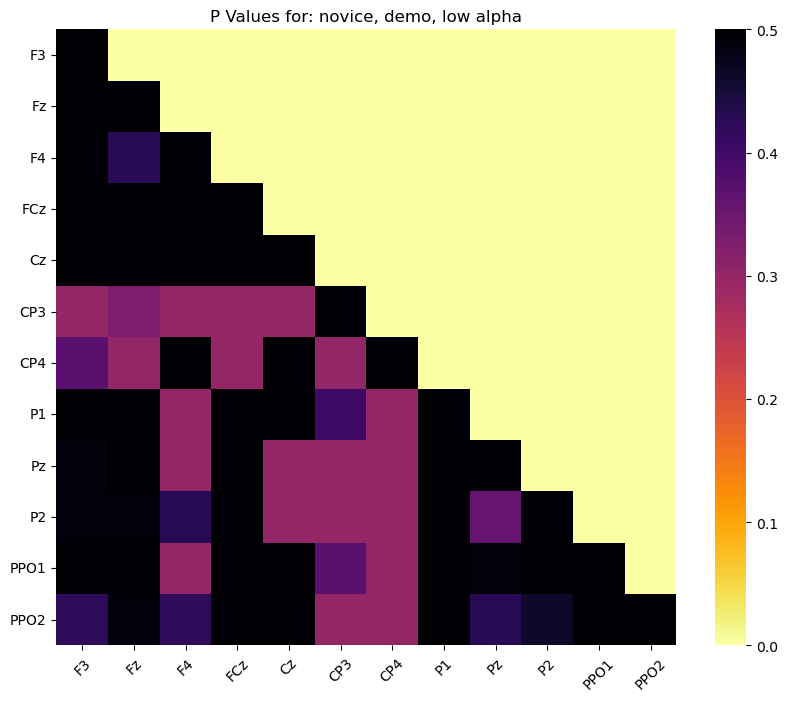

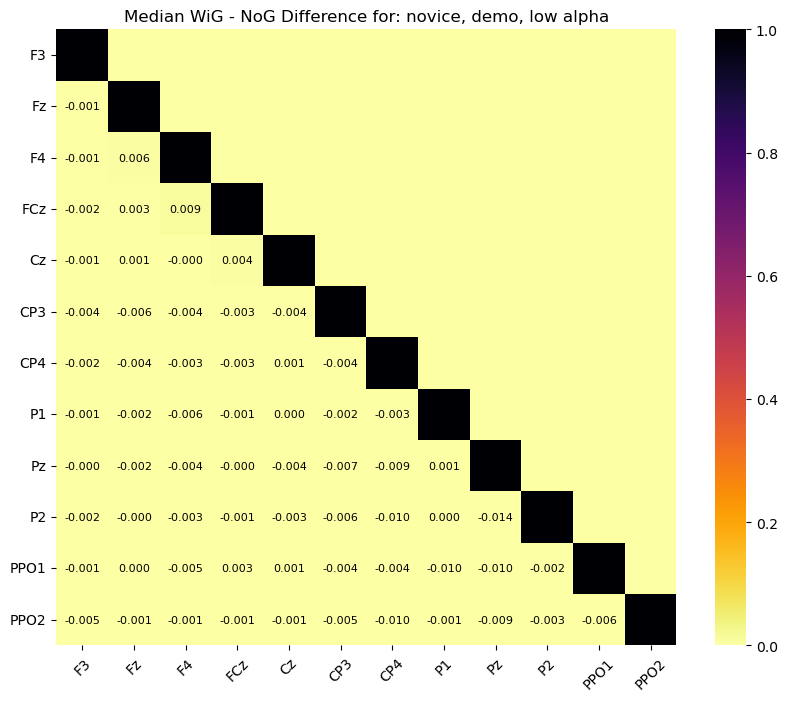

Condition: BL


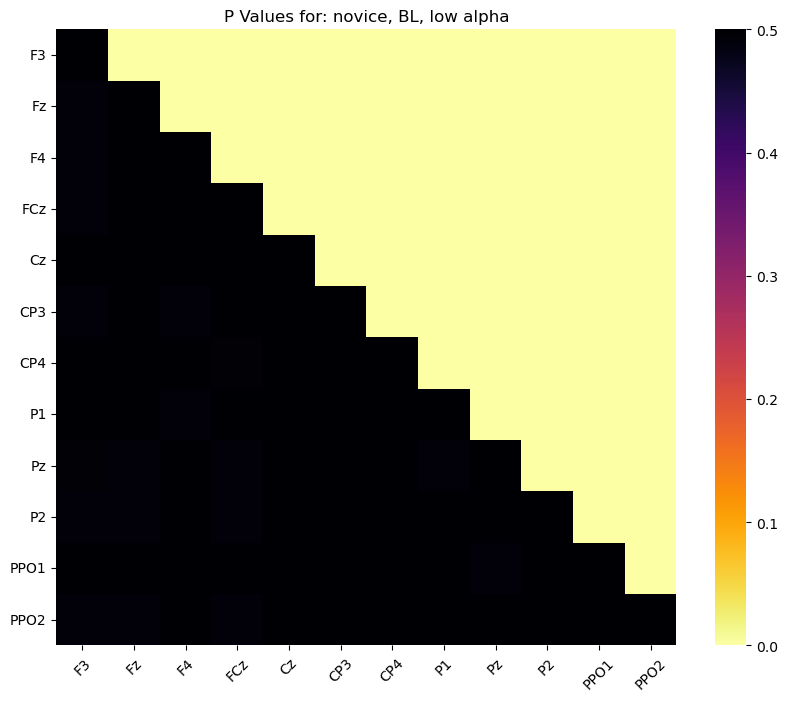

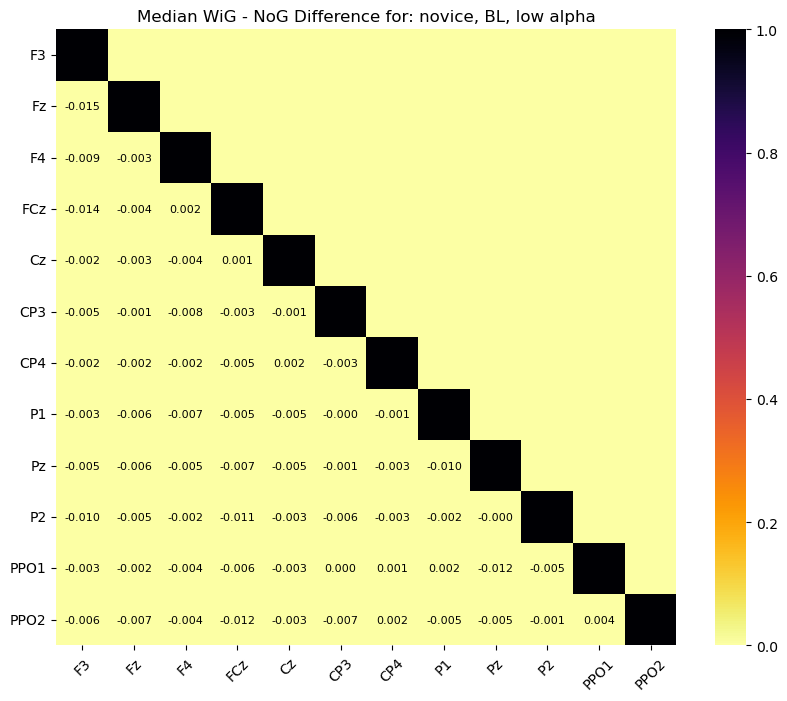

Group: expert
Condition: demo


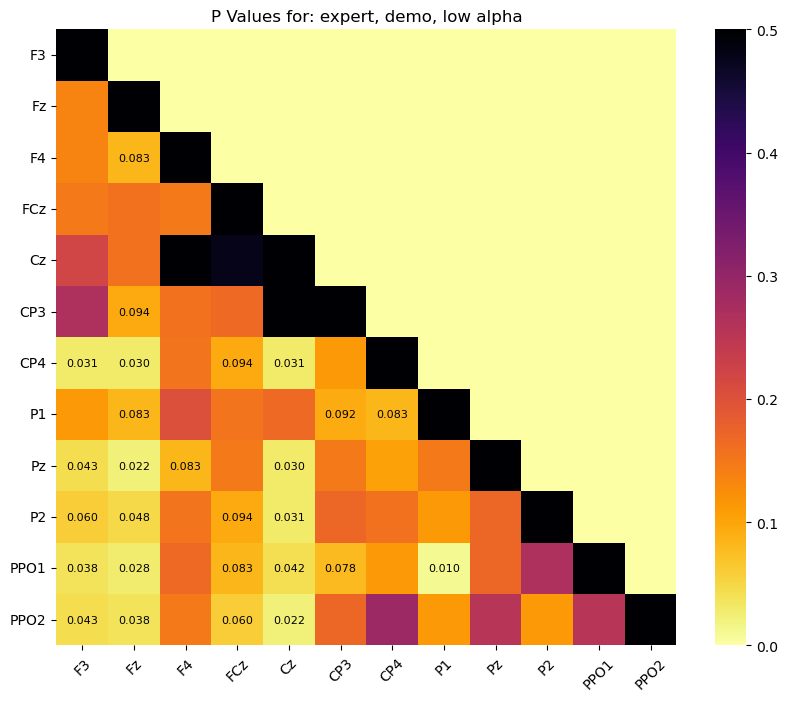

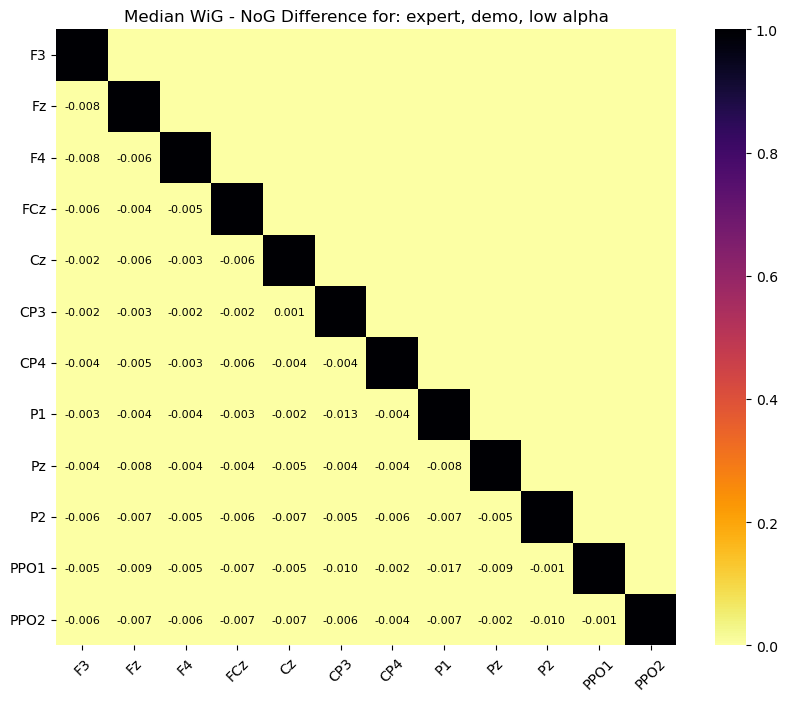

Condition: BL


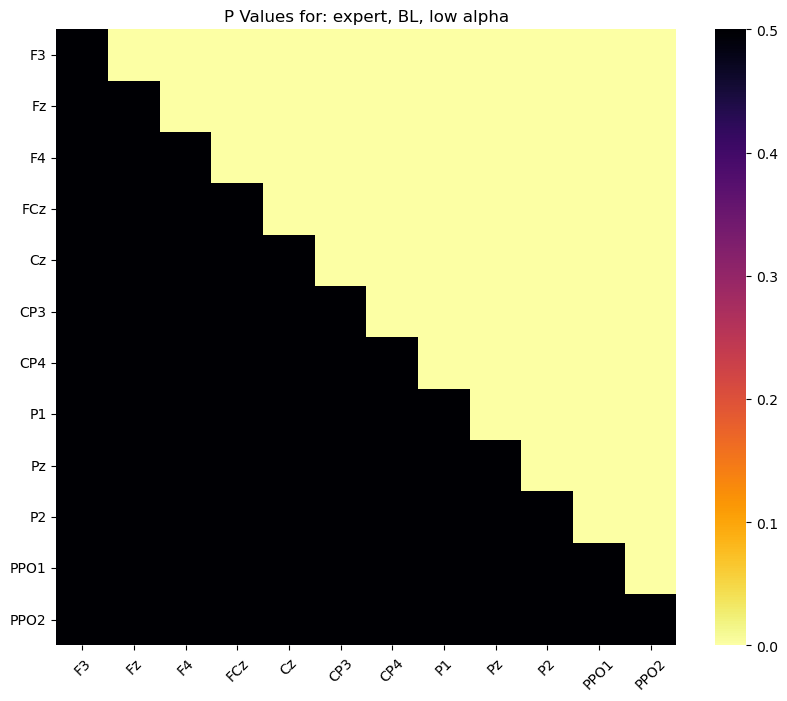

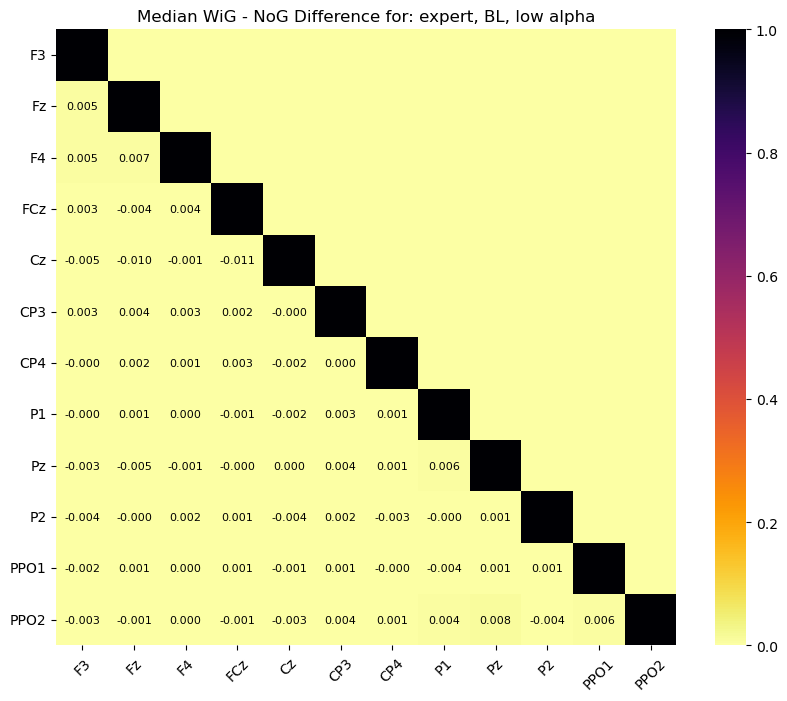

In [32]:
gesticulation_1 = "WiG"
gesticulation_2 = "NoG"
frequency_band = "low alpha"

for group in ["novice", "expert"]:
    print ("Group: {}".format(group))
    for condition in ["demo", "BL"]:
        print("Condition: {}".format(condition))
        gesticulation_1_data = dataset.get_frequency_average(group, condition, gesticulation_1, frequency_band)
        gesticulation_2_data = dataset.get_frequency_average(group, condition, gesticulation_2, frequency_band)

        p_values, test_stats, median_diffs = run_wilcoxon(gesticulation_1_data, gesticulation_2_data)
        plot_heatmap(p_values, dataset.electrode_names, "P Values for: {}, {}, {}".format(group, condition, frequency_band), print_max=0.1, vmin=0, vmax=0.5)
        plot_heatmap(median_diffs, dataset.electrode_names, "Median WiG - NoG Difference for: {}, {}, {}".format(group, condition, frequency_band), vmax=1, vmin=0)

#### 2.a.2 Experiment Results:


#### 2.a.2 Possible Explanations of Results:



### 2.b) Multiple  Measures Anova
This test considers the baseline or demo data in isolation. It separates experts and novices as the "group" split and WiG vs NoG as the "condition" split. P values for group and condition indicate significant differences in either. Additionally, interaction p values indicate significant interactions between group and condition.

When significant results are identified, the directionality is inspected by comparing the mean difference.
#### 2.b.1 Experiment Setup
* Baseline data only

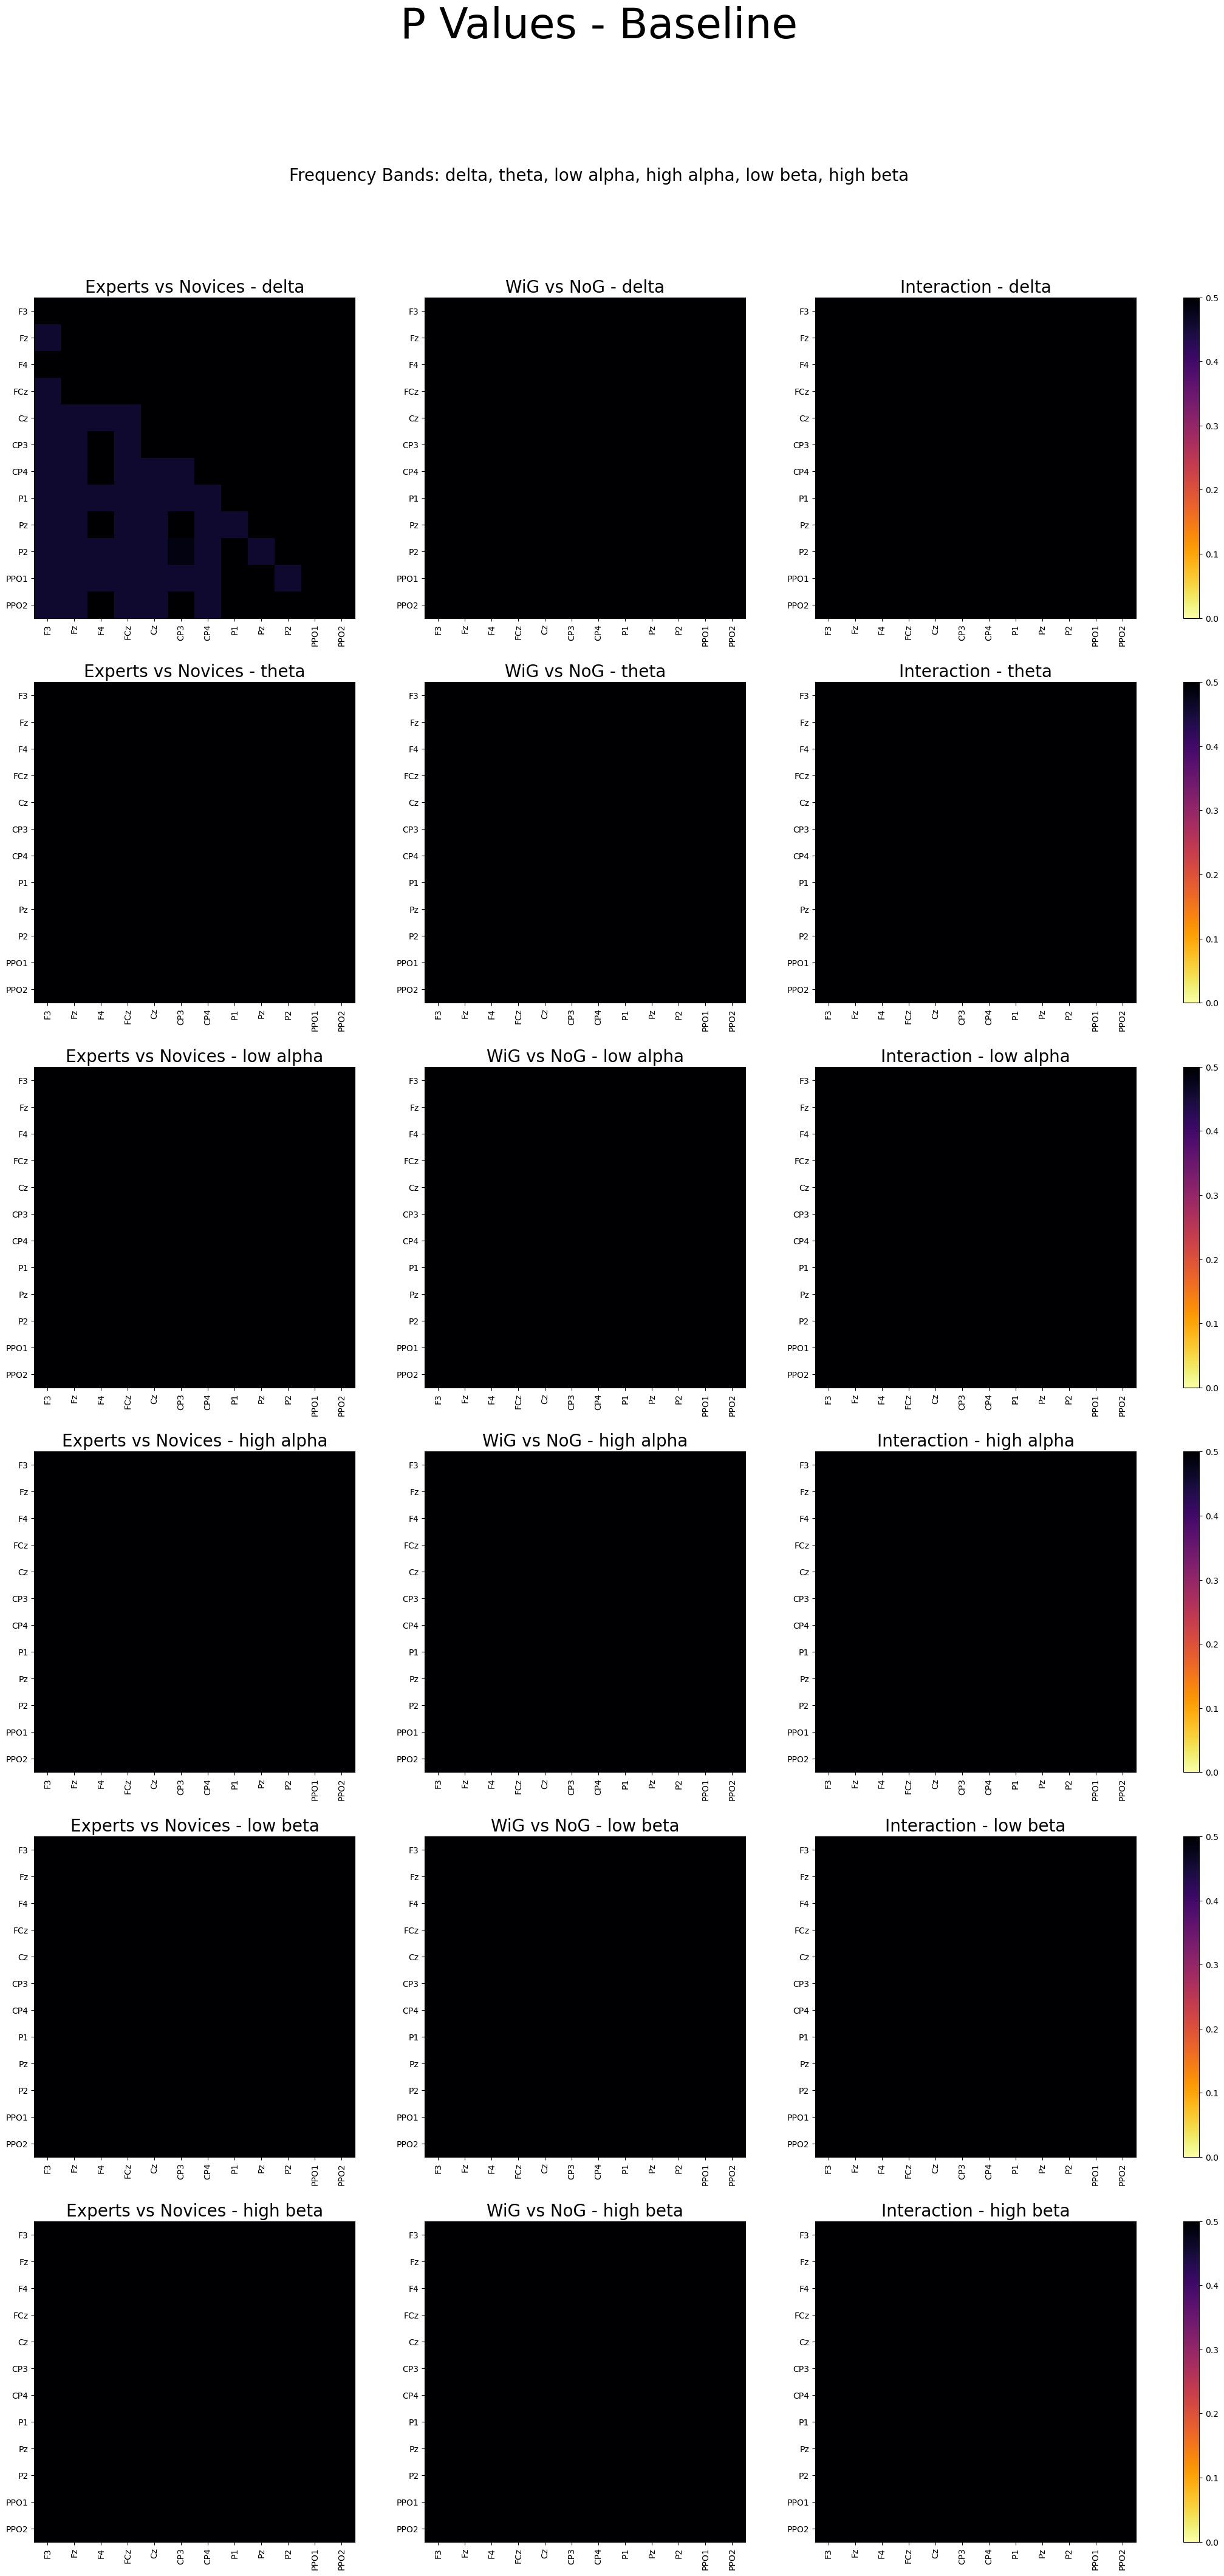

In [33]:
# Store lists of p values with one entry for each frequency band
all_group_ps = []
all_condition_ps = []
all_interaction_ps = []

# Iterate through all frequency bands and run ANOVA tests for each
frequency_bands = ["delta", "theta", "low alpha", "high alpha", "low beta", "high beta"]
for freq in frequency_bands:
    # Only consider baseline data
    # Define Group A as experts and Group B as novices
    # Define Condition 1 as WiG and Condition 2 as NoG
    group_a_condition_1 = dataset.get_frequency_average("expert", "BL", "WiG", freq)
    group_a_condition_2 = dataset.get_frequency_average("expert", "BL", "NoG", freq)

    group_b_condition_1 = dataset.get_frequency_average("novice", "BL", "WiG", freq)
    group_b_condition_2 = dataset.get_frequency_average("novice", "BL", "NoG", freq)

    # Run ANOVA tests
    p_values_group, p_values_condition, p_values_interaction = run_anova(group_a_condition_1, group_a_condition_2, group_b_condition_1, group_b_condition_2)

    # Store p values
    all_group_ps.append(p_values_group)
    all_condition_ps.append(p_values_condition)
    all_interaction_ps.append(p_values_interaction)


# Plot p values fro group, condition, and interaction across all frequency bands
plot_stacked_triple_ps(all_group_ps, all_condition_ps, all_interaction_ps, frequency_bands, dataset.electrode_names, title="P Values - Baseline", sub_title_1="Experts vs Novices", sub_title_2="WiG vs NoG", sub_title_3="Interaction", save_path=None)

#### 2.b.1 Experiment Results:


#### 2.b.1 Possible Explanations of Results:



#### 2.b.2 Experiment Setup
* Demo data only

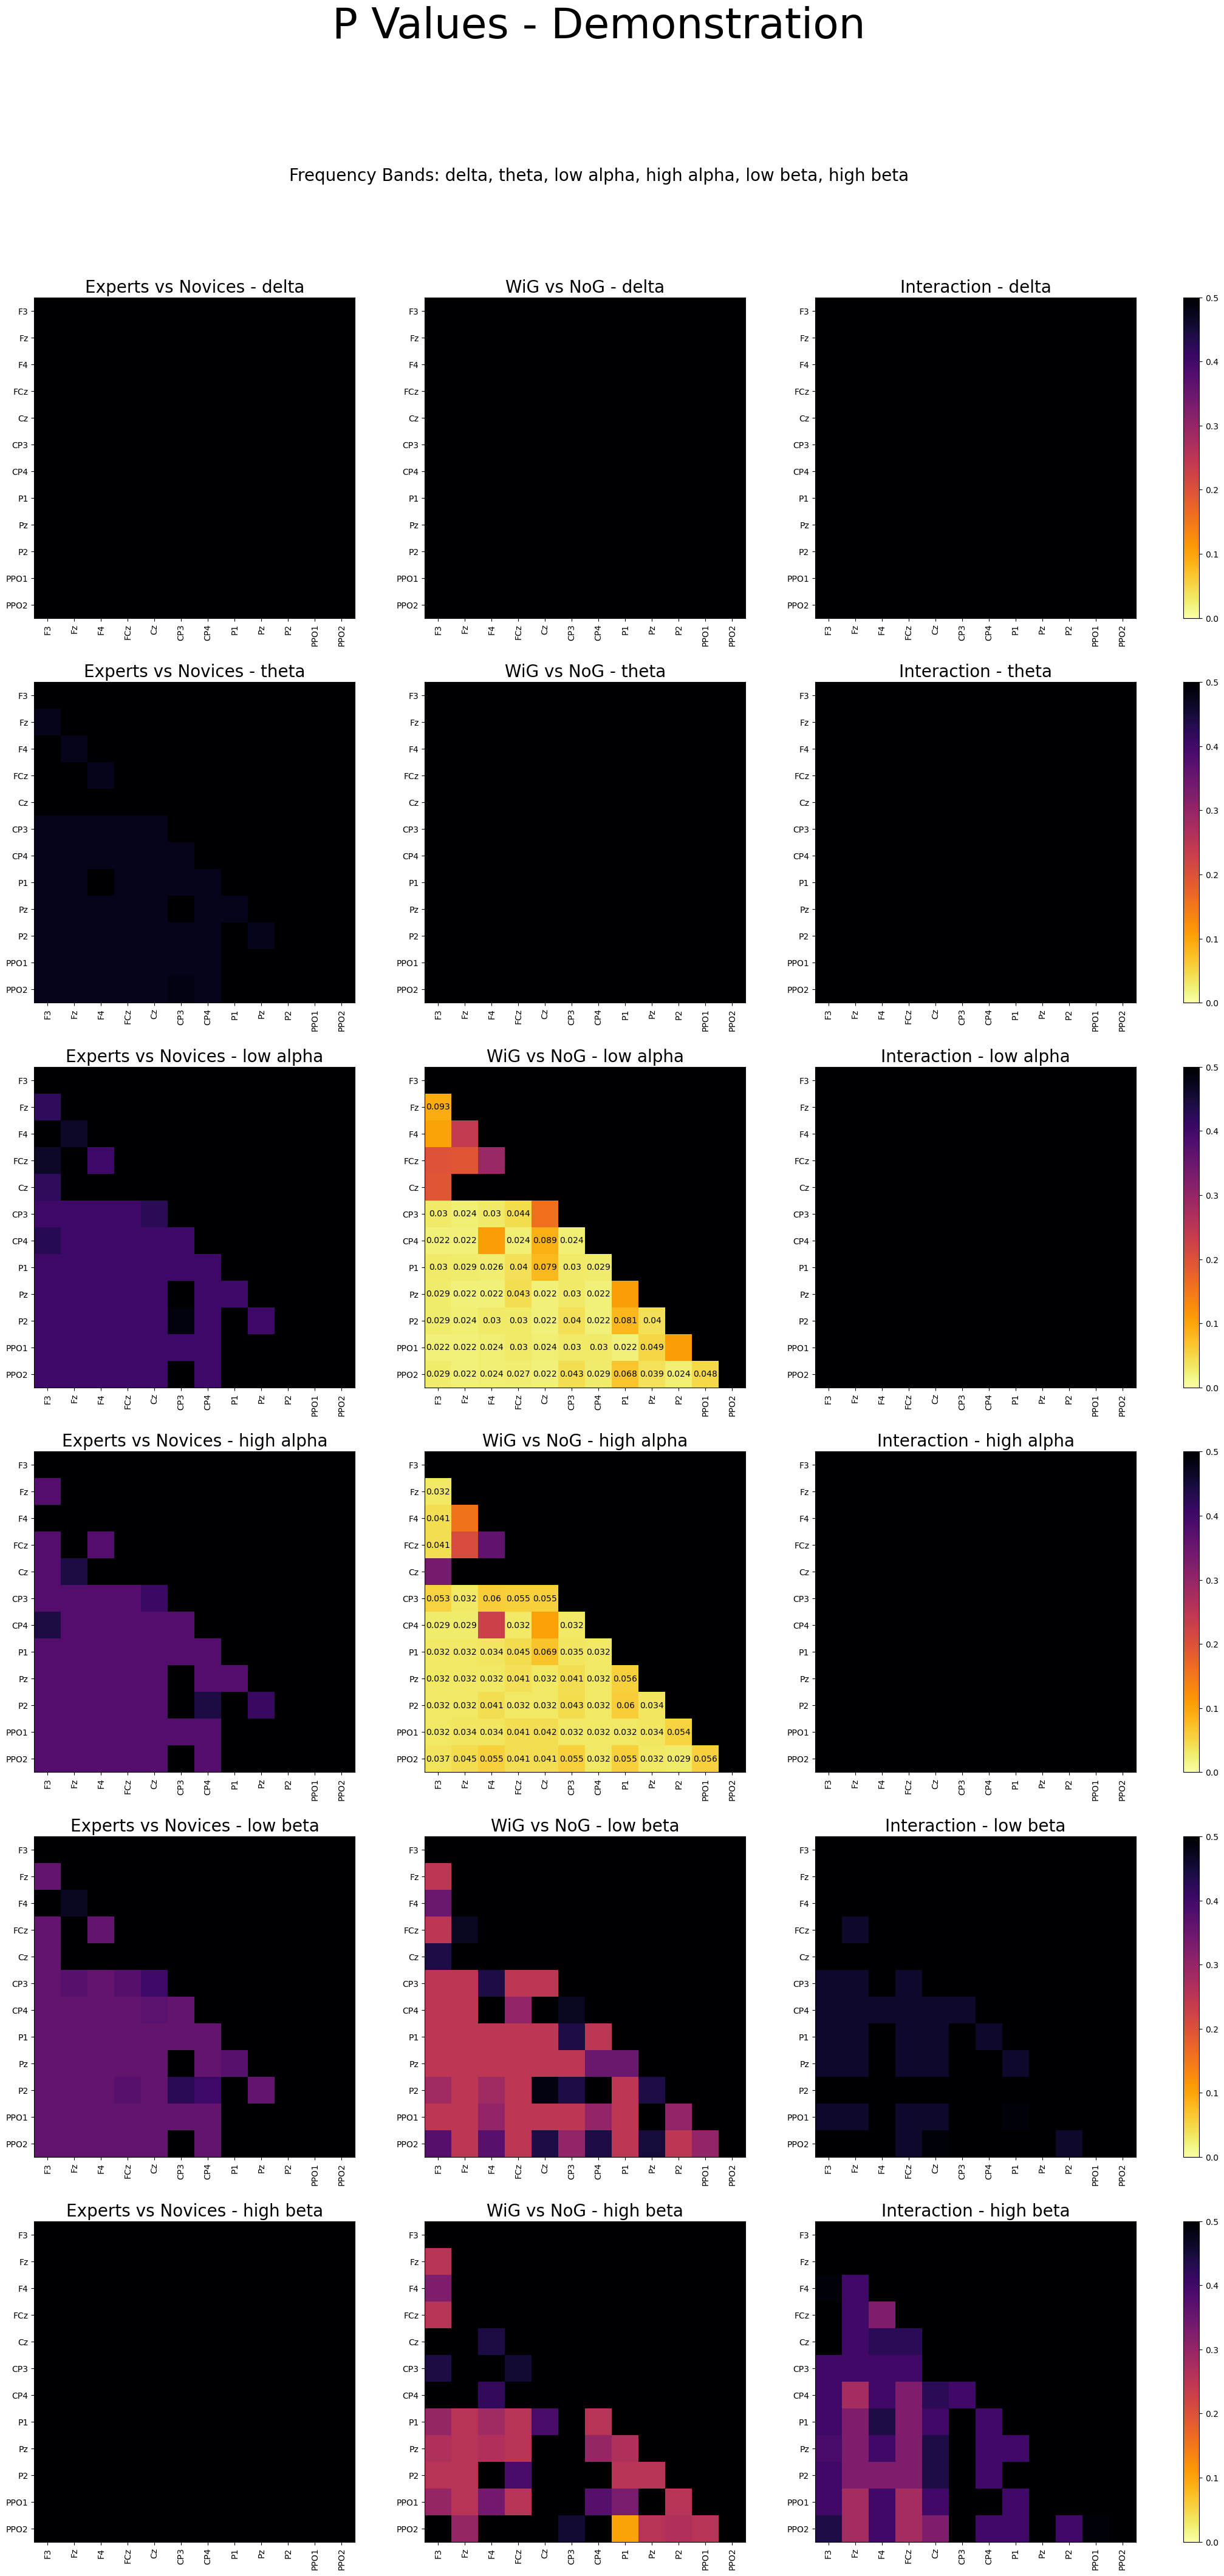

In [34]:
# Store lists of p values with one entry for each frequency band
all_group_ps = []
all_condition_ps = []
all_interaction_ps = []

# Iterate through all frequency bands and run ANOVA tests for each
frequency_bands = ["delta", "theta", "low alpha", "high alpha", "low beta", "high beta"]
for freq in frequency_bands:
    # Only consider demo data
    # Define Group A as experts and Group B as novices
    # Define Condition 1 as WiG and Condition 2 as NoG
    group_a_condition_1 = dataset.get_frequency_average("expert", "demo", "WiG", freq)
    group_a_condition_2 = dataset.get_frequency_average("expert", "demo", "NoG", freq)

    group_b_condition_1 = dataset.get_frequency_average("novice", "demo", "WiG", freq)
    group_b_condition_2 = dataset.get_frequency_average("novice", "demo", "NoG", freq)

    # Run ANOVA tests
    p_values_group, p_values_condition, p_values_interaction = run_anova(group_a_condition_1, group_a_condition_2, group_b_condition_1, group_b_condition_2)

    # Store p values
    all_group_ps.append(p_values_group)
    all_condition_ps.append(p_values_condition)
    all_interaction_ps.append(p_values_interaction)


# Plot p values fro group, condition, and interaction across all frequency bands
plot_stacked_triple_ps(all_group_ps, all_condition_ps, all_interaction_ps, frequency_bands, dataset.electrode_names, title="P Values - Demonstration", sub_title_1="Experts vs Novices", sub_title_2="WiG vs NoG", sub_title_3="Interaction", save_path=None)

##### Exploration of Directionality in Low Alpha

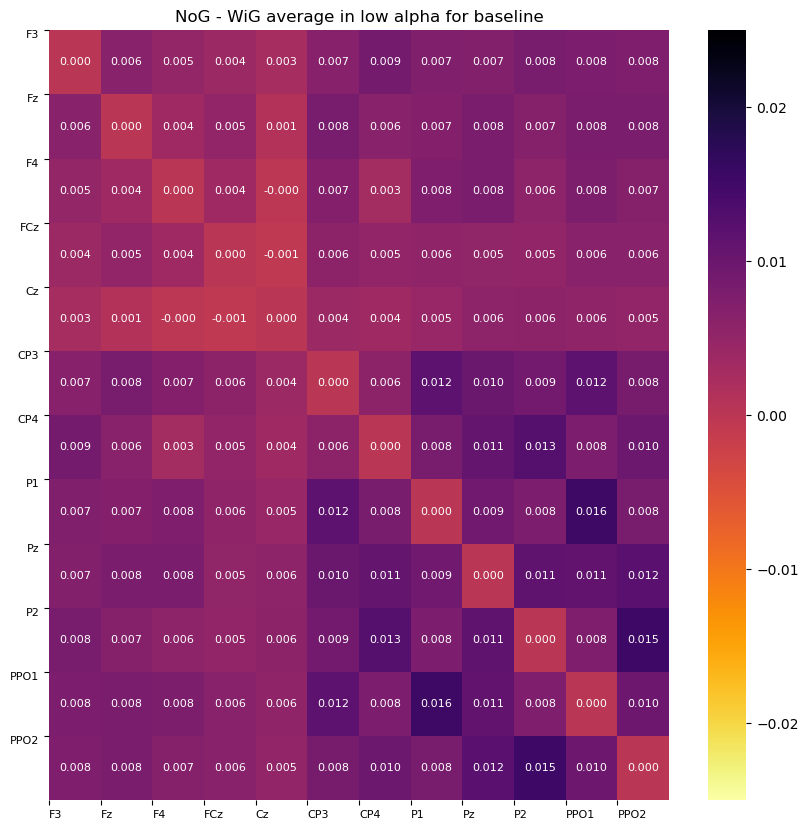

In [35]:
group_a_condition_1 = dataset.get_frequency_average("expert", "demo", "WiG", "low alpha")
group_a_condition_2 = dataset.get_frequency_average("expert", "demo", "NoG", "low alpha")

group_b_condition_1 = dataset.get_frequency_average("novice", "demo", "WiG", "low alpha")
group_b_condition_2 = dataset.get_frequency_average("novice", "demo", "NoG", "low alpha")

plot_condition_diff_avg(group_a_condition_1, group_a_condition_2, group_b_condition_1, group_b_condition_2, dataset, title=f"NoG - WiG average in low alpha for baseline")

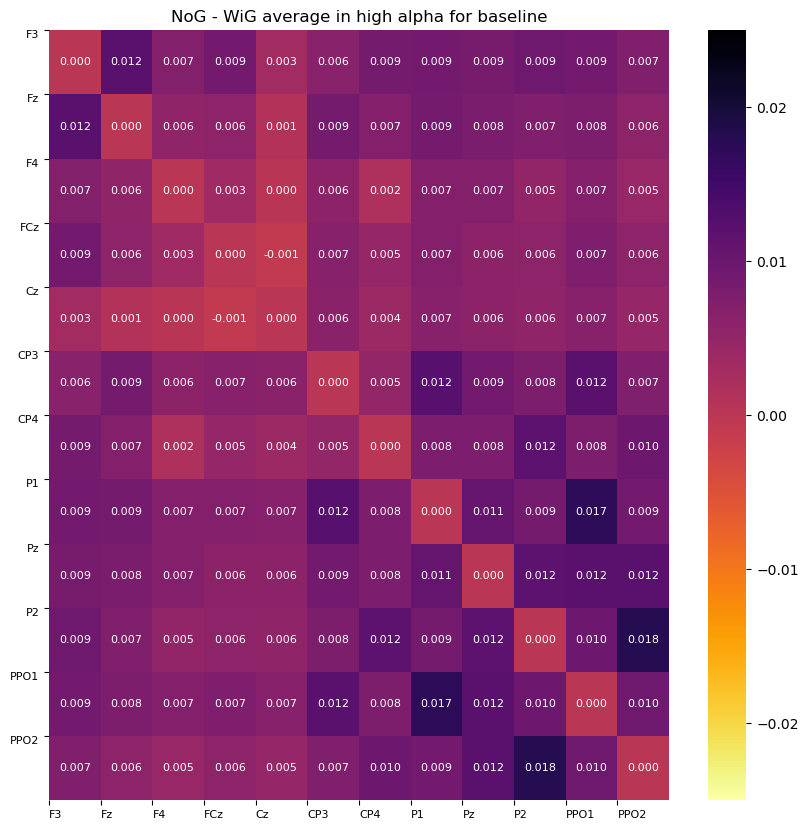

In [36]:
group_a_condition_1 = dataset.get_frequency_average("expert", "demo", "WiG", "high alpha")
group_a_condition_2 = dataset.get_frequency_average("expert", "demo", "NoG", "high alpha")

group_b_condition_1 = dataset.get_frequency_average("novice", "demo", "WiG", "high alpha")
group_b_condition_2 = dataset.get_frequency_average("novice", "demo", "NoG", "high alpha")

plot_condition_diff_avg(group_a_condition_1, group_a_condition_2, group_b_condition_1, group_b_condition_2, dataset, title=f"NoG - WiG average in high alpha for baseline")

#### 2.b.2 Experiment Results:

* No statistical group differences observed
* Statistically significant condition differences between WiG and NoG during demonstration
* NoG - WiG values positive indicating HIGHER NoG connectivity

#### 2.b.2 Possible Explanations of Results:
* Higher cognitive load -> lower connectivity, drop in alpha synchrony is indicative of effective mathematical processing.
* This drop in connectivity occurs (as it should during a hard task) for both experts and novices (TODO: if we separate experts and novices, how do the groups compare?)
